In [4]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import scanpy.external as sce
# import harmonypy as hm
import pandas as pd
import geopandas as gpd

import pickle
import scipy

import seaborn as sns

from SGanalysis.SGobject import SGobject

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

matplotlib.rcParams['pdf.fonttype'] = 42

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['font.size'] = 6  # Set default font size for all text elements
plt.rcParams['axes.labelsize'] = 8  # Set font size for axis labels
plt.rcParams['xtick.labelsize'] = 6  # Set font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Set font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 6  # Set font size for legend text


# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'
tools_path = '../helperScripts/tools.py'
# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'

# /Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

In [5]:
import pandas as pd
import pickle
import numpy as np

def merge_multiple_datasets(roi_list, tools, file_date='20240718'):
    """
    Merge multiple datasets while preserving unique object IDs and spatial locations.
    
    Parameters:
    roi_list: list of ROI identifiers
    tools: object containing roi_file_paths
    file_date: date string for file naming
    
    Returns:
    merged_df: combined dataframe with unique IDs
    merged_sg_obj: combined spatial graph object
    merged_sister_cells: combined sister cells dictionary
    """
    
    all_dfs = []
    all_sg_objs = []
    all_sister_cells = {}
    
    # Track global maximums to ensure unique IDs
    max_object_id = 0
    
    for roi_idx, roi_of_interest in enumerate(roi_list):
        print(f"Processing {roi_of_interest} (dataset {roi_idx + 1}/{len(roi_list)})")
        
        # Load the sg_object
        with open(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/sg_object_dilate10_{file_date}.pkl', 'rb') as f:
            sg_obj = pickle.load(f)
        
        # Load the dataframes
        unclustered_df = pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_{file_date}_withbarcodes_atleast3.csv')
        clustered_df = pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_{file_date}_withbarcodes_clustering_10bcs_0.2thresh.csv')
        
        # Create unique object IDs by adding offset
        original_object_ids = unclustered_df['object_id'].copy()
        unclustered_df['original_object_id'] = original_object_ids
        clustered_df['original_object_id'] = clustered_df['object_id'].copy()
        
        # Add offset to make IDs unique across datasets
        unclustered_df['object_id'] = unclustered_df['object_id'] + max_object_id
        clustered_df['object_id'] = clustered_df['object_id'] + max_object_id
        
        # Update max_object_id for next iteration
        max_object_id = unclustered_df['object_id'].max() + 1
        
        # Add dataset identifier
        unclustered_df['dataset'] = roi_of_interest
        clustered_df['dataset'] = roi_of_interest
        unclustered_df['dataset_idx'] = roi_idx
        clustered_df['dataset_idx'] = roi_idx
        
        # Merge clustered and unclustered dataframes
        cols_to_keep = ['object_id','bc_cluster','bc_cluster_n_bcs','bc_cluster_found_bcs','bc_cluster_bc_names']
        df = unclustered_df.merge(clustered_df[cols_to_keep], on='object_id', how='left')
        
        # Create cell_id
        df['cell_id'] = [f"{roi_of_interest}_{id}" for id in df['original_object_id']]
        
        # Process sg_obj with unique IDs
        # Handle both string and numeric indices
        if sg_obj.gdf.index.dtype == 'object' or sg_obj.gdf.index.dtype.kind in ['U', 'S']:
            # If index is string, create numeric mapping
            sg_obj.gdf['original_object_id'] = range(len(sg_obj.gdf))
            sg_obj.gdf['object_id'] = [i + (max_object_id - len(sg_obj.gdf)) for i in range(len(sg_obj.gdf))]
        else:
            # If index is numeric, use it directly
            sg_obj.gdf['original_object_id'] = sg_obj.gdf.index.copy()
            sg_obj.gdf['object_id'] = sg_obj.gdf.index + (max_object_id - len(sg_obj.gdf))
        
        sg_obj.gdf['cell_id'] = [f"{roi_of_interest}_{id}" for id in sg_obj.gdf['original_object_id']]
        sg_obj.gdf['dataset'] = roi_of_interest
        sg_obj.gdf['dataset_idx'] = roi_idx
        sg_obj.gdf.index.name = 'index'
        sg_obj.gdf = sg_obj.gdf.sort_values('object_id')
        
        # Add spatial offset to preserve physical separation (optional - adjust as needed)
        # This assumes you have x,y coordinates in sg_obj.gdf
        if 'x' in sg_obj.gdf.columns and 'y' in sg_obj.gdf.columns:
            # Add large offset to separate datasets spatially
            x_offset = roi_idx * 10000  # Adjust multiplier as needed
            y_offset = roi_idx * 10000  # Adjust multiplier as needed
            sg_obj.gdf['x'] = sg_obj.gdf['x'] + x_offset
            sg_obj.gdf['y'] = sg_obj.gdf['y'] + y_offset
            # Keep original coordinates for reference
            sg_obj.gdf['original_x'] = sg_obj.gdf['x'] - x_offset
            sg_obj.gdf['original_y'] = sg_obj.gdf['y'] - y_offset
        
        # Merge with df data
        merge_cols = ['cell_id'] + list(df.columns.difference(sg_obj.gdf.columns))
        sg_obj.gdf = sg_obj.gdf.merge(df[merge_cols], on=['cell_id'], how='left')
        
        # Create sister cells dictionary for this dataset
        cutoff = 3
        dataset_sister_cells = {}
        
        for bc_set in np.unique(df[df['n_called_barcodes']>=cutoff]['barcode_names'].values):
            if len(df[df['barcode_names']==bc_set]) >= 2:
                # Create unique barcode set name to avoid conflicts
                unique_bc_set = f"{roi_of_interest}_{bc_set}"
                dataset_sister_cells[unique_bc_set] = df[df['barcode_names']==bc_set].index
        
        # Store processed data
        all_dfs.append(df)
        all_sg_objs.append(sg_obj)
        all_sister_cells.update(dataset_sister_cells)
    
    # Combine all dataframes
    merged_df = pd.concat(all_dfs, ignore_index=True)
    
    # Combine all sg_obj.gdf DataFrames
    merged_gdf = pd.concat([sg_obj.gdf for sg_obj in all_sg_objs], ignore_index=True)
    
    # Create a merged sg_obj (using the first one as template)
    merged_sg_obj = all_sg_objs[0]  # Use first as template
    merged_sg_obj.gdf = merged_gdf
    
    print(f"\nMerging complete!")
    print(f"Total cells: {len(merged_df)}")
    print(f"Total datasets: {len(roi_list)}")
    print(f"Object ID range: {merged_df['object_id'].min()} - {merged_df['object_id'].max()}")
    print(f"Sister cell groups: {len(all_sister_cells)}")
    
    return merged_df, merged_sg_obj, all_sister_cells

# Usage example:
roi_list = ['dish_roi1','dish_roi2','dish_roi3']

# Call the function
merged_df, merged_sg_obj, merged_sister_cells = merge_multiple_datasets(roi_list, tools)

# Access your data as before, but now it's merged:
df = merged_df
sg_obj = merged_sg_obj
sister_cells = merged_sister_cells

# Optional: Save merged data
# merged_df.to_csv('merged_cell_by_gene_matrix.csv', index=False)
# with open('merged_sg_object.pkl', 'wb') as f:
#     pickle.dump(merged_sg_obj, f)

# Example analysis on merged data
print(f"\nDataset distribution:")
print(merged_df['dataset'].value_counts())

print(f"\nSample sister cell groups:")
for i, (bc_set, indices) in enumerate(list(merged_sister_cells.items())[:3]):
    print(f"  {bc_set}: {len(indices)} cells")

Processing dish_roi1 (dataset 1/3)
Processing dish_roi2 (dataset 2/3)
Processing dish_roi3 (dataset 3/3)

Merging complete!
Total cells: 45988
Total datasets: 3
Object ID range: 1 - 46000
Sister cell groups: 3878

Dataset distribution:
dish_roi2    16376
dish_roi1    15827
dish_roi3    13785
Name: dataset, dtype: int64

Sample sister cell groups:
  dish_roi1_bc_001-bc_002-bc_005-bc_014-bc_063: 2 cells
  dish_roi1_bc_001-bc_002-bc_006: 5 cells
  dish_roi1_bc_001-bc_002-bc_007-bc_065-bc_086: 2 cells


In [6]:
df

,object_id,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,...,center_x,center_y,area,original_object_id,dataset,dataset_idx,bc_cluster,bc_cluster_n_bcs,bc_cluster_found_bcs,bc_cluster_bc_names
0,1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,24.0,...,484.298587,37.273585,15039.211479,1,dish_roi1,0,NaN,NaN,NaN,NaN
1,10,1.0,0.0,0.0,0.0,0.0,0.0,1.0,19.0,20.0,...,6592.362874,17.851878,6508.865478,10,dish_roi1,0,4667.0,0.0,[],NaN
2,100,0.0,0.0,0.0,2.0,0.0,3.0,0.0,17.0,116.0,...,16250.554479,186.004663,22482.686608,100,dish_roi1,0,4347.0,5.0,"['bc_031', 'bc_044', 'bc_046', 'bc_054', 'bc_0...",bc_031-bc_044-bc_046-bc_054-bc_063
3,1000,2.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,18.0,...,12882.929669,2415.253765,9942.971610,1000,dish_roi1,0,NaN,NaN,NaN,NaN
4,10000,5.0,0.0,0.0,1.0,9.0,0.0,0.0,10.0,95.0,...,681.689287,22827.877405,17882.368807,10000,dish_roi1,0,2972.0,2.0,"['bc_084', 'bc_087']",bc_084-bc_087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45983,42204,7.0,0.0,0.0,0.0,8.0,0.0,0.0,2.0,8.0,...,27608.662277,26289.276164,13530.901301,9995,dish_roi3,2,NaN,NaN,NaN,NaN
45984,42205,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,30.0,...,6180.485742,26308.001256,15620.297846,9996,dish_roi3,2,120.0,5.0,"['bc_039', 'bc_079', 'bc_085', 'bc_088', 'bc_0...",bc_039-bc_079-bc_085-bc_088-bc_091
45985,42206,5.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,19.0,...,2918.738764,26299.674838,14857.574864,9997,dish_roi3,2,2352.0,2.0,"['bc_055', 'bc_073']",bc_055-bc_073
45986,42207,4.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,11.0,...,15170.180786,26304.648711,14079.420329,9998,dish_roi3,2,2377.0,3.0,"['bc_014', 'bc_035', 'bc_064']",bc_014-bc_035-bc_064


In [31]:
# remove serial genes (which are manually thresholded and poorly detected genes)

serial_genes = tools.gene_cols[:20]

df_clean = df[[col for col in tools.gene_cols if (col in df.columns and col not in tools.genes_to_exclude and col not in serial_genes)]].fillna(0)
adata_genes = sc.AnnData(df_clean)


/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_40544/69409898.py:6: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_genes = sc.AnnData(df_clean)
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [32]:
adata_genes.obs['cell_id'] = df['cell_id'].values
adata_genes.obs['dataset'] = df['dataset'].values
adata_genes.obs['dataset_idx'] = df['dataset_idx'].values
adata_genes.obs['object_id'] = df['object_id'].values
adata_genes.obs['bc_cluster'] = df['bc_cluster'].values
adata_genes.obs['bc_cluster_n_bcs'] = df['bc_cluster_n_bcs'].values
adata_genes.obs['bc_cluster_found_bcs'] = df['bc_cluster_found_bcs'].values
adata_genes.obs['bc_cluster_bc_names'] = df['bc_cluster_bc_names'].values
adata_genes.obs['n_called_barcodes'] = df['n_called_barcodes'].values
adata_genes.obs['barcode_names'] = df['barcode_names'].values

In [33]:
df['dataset'].values

array(['dish_roi1', 'dish_roi1', 'dish_roi1', ..., 'dish_roi3',
       'dish_roi3', 'dish_roi3'], dtype=object)

In [34]:
# log(x+1) transform the data
sc.pp.log1p(adata_genes)

In [35]:
adata_genes

AnnData object with n_obs × n_vars = 45988 × 94
    obs: 'cell_id', 'dataset', 'dataset_idx', 'object_id', 'bc_cluster', 'bc_cluster_n_bcs', 'bc_cluster_found_bcs', 'bc_cluster_bc_names', 'n_called_barcodes', 'barcode_names'
    uns: 'log1p'

/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


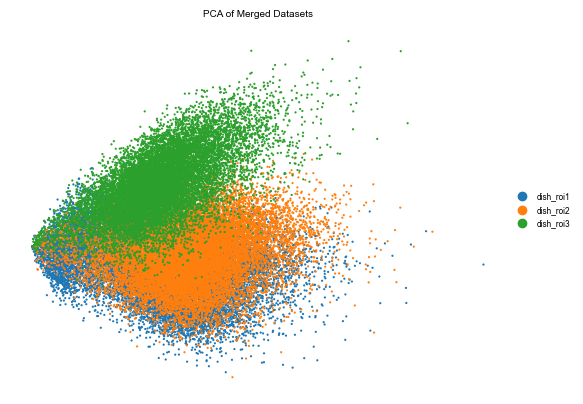

/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


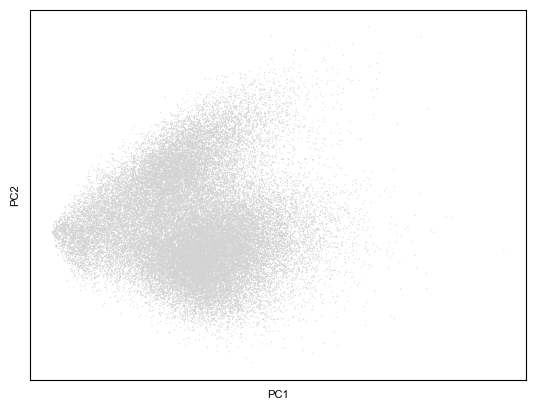

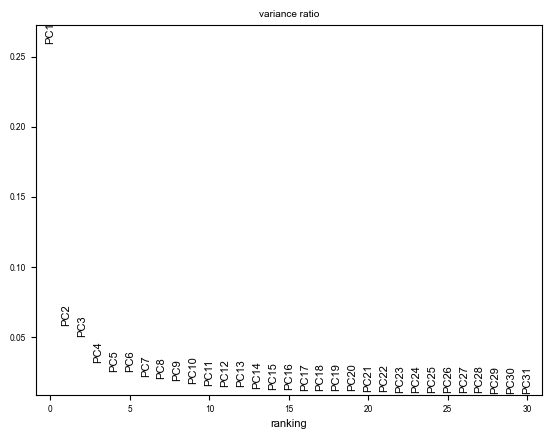

In [38]:
# perform and plot PCA 
sc.pp.pca(adata_genes)
sc.pl.pca(adata_genes, color='dataset', size=10, frameon=False, title='PCA of Merged Datasets')
sc.pl.pca(adata_genes)
sc.pl.pca_variance_ratio(adata_genes, log=False)

In [39]:
sc.pp.neighbors(adata_genes)

In [40]:
# perform leiden clustering
# sc.pp.scale(adata_genes)
sc.tl.umap(adata_genes)
sc.tl.leiden(adata_genes, n_iterations=-1)

In [41]:
adata_genes.obs

,cell_id,dataset,dataset_idx,object_id,bc_cluster,bc_cluster_n_bcs,bc_cluster_found_bcs,bc_cluster_bc_names,n_called_barcodes,barcode_names,leiden
0,dish_roi1_1,dish_roi1,0,1,NaN,NaN,NaN,NaN,1,bc_006,10
1,dish_roi1_10,dish_roi1,0,10,4667.0,0.0,[],NaN,1,bc_076,2
2,dish_roi1_100,dish_roi1,0,100,4347.0,5.0,"['bc_031', 'bc_044', 'bc_046', 'bc_054', 'bc_0...",bc_031-bc_044-bc_046-bc_054-bc_063,9,bc_019-bc_031-bc_044-bc_046-bc_054-bc_060-bc_0...,6
3,dish_roi1_1000,dish_roi1,0,1000,NaN,NaN,NaN,NaN,1,bc_075,2
4,dish_roi1_10000,dish_roi1,0,10000,2972.0,2.0,"['bc_084', 'bc_087']",bc_084-bc_087,2,bc_084-bc_087,1
...,...,...,...,...,...,...,...,...,...,...,...
45983,dish_roi3_9995,dish_roi3,2,42204,NaN,NaN,NaN,NaN,0,NaN,0
45984,dish_roi3_9996,dish_roi3,2,42205,120.0,5.0,"['bc_039', 'bc_079', 'bc_085', 'bc_088', 'bc_0...",bc_039-bc_079-bc_085-bc_088-bc_091,7,bc_033-bc_039-bc_076-bc_079-bc_085-bc_088-bc_091,0
45985,dish_roi3_9997,dish_roi3,2,42206,2352.0,2.0,"['bc_055', 'bc_073']",bc_055-bc_073,2,bc_055-bc_073,0
45986,dish_roi3_9998,dish_roi3,2,42207,2377.0,3.0,"['bc_014', 'bc_035', 'bc_064']",bc_014-bc_035-bc_064,3,bc_014-bc_035-bc_064,0


/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


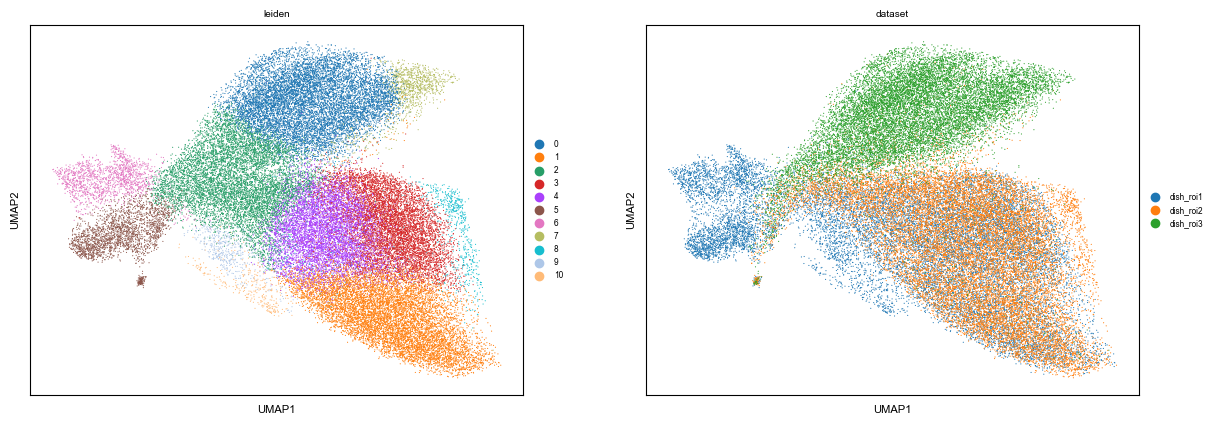

In [42]:
sc.pl.umap(adata_genes, color=["leiden","dataset"])

/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


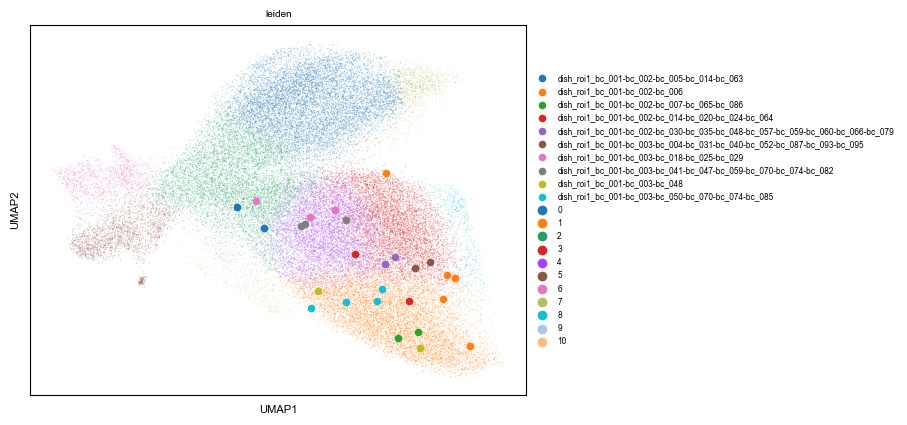

In [43]:
# plot sets of sisters on the UMAP

fig,ax = plt.subplots()
for b,(bc_set,ix) in enumerate(sister_cells.items()):
    if b < 10:
        umap_coords = adata_genes[ix].obsm['X_umap']
        ax.scatter(umap_coords[:,0],umap_coords[:,1],s=20,zorder=10,label=bc_set) 
sc.pl.umap(adata_genes, color=["leiden"],ax=ax,alpha=0.3)

 

In [44]:
# cells do appear to be closer in the umap, but let's also adjust for cell cycle:
cell_cycle_genes = tools.regev_cell_cycle_genes
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata_genes.var_names]

In [45]:
sc.tl.score_genes(adata_genes,cell_cycle_genes,score_name='g2m_score')

/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


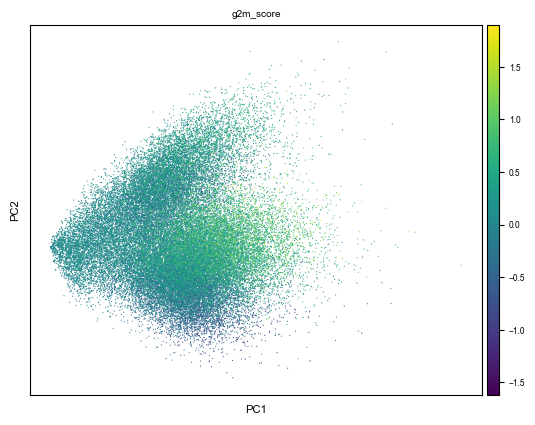

In [46]:
sc.pl.pca(adata_genes,color='g2m_score')

In [20]:
# # regress out the cell cycle score
# sc.pp.regress_out(adata_genes, ['g2m_score'])
# sc.pp.scale(adata_genes)
# perform new PCA with the regressed out data
# sc.pp.pca(adata_genes)
# sc.pl.pca(adata_genes)

/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


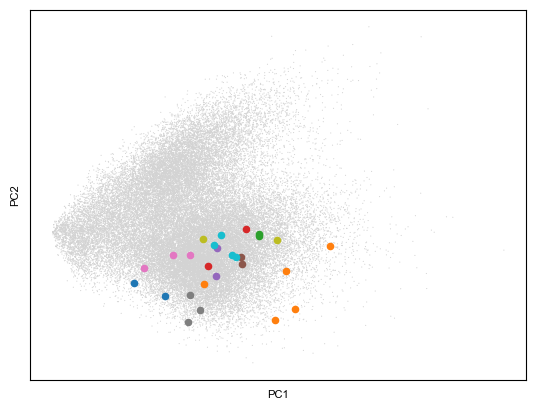

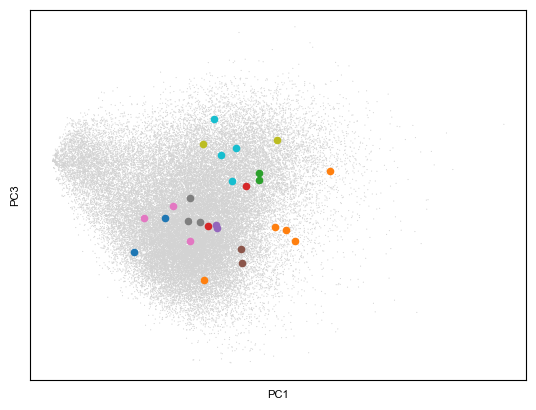

In [47]:
# perform PCA on the 

fig,ax = plt.subplots()
for b,(bc_set,ix) in enumerate(sister_cells.items()):
    if b < 10:
        pca_coords = adata_genes[ix].obsm['X_pca']
        ax.scatter(pca_coords[:,0],pca_coords[:,1],s=20,zorder=10,label=bc_set) 

sc.pl.pca(adata_genes,ax=ax,components='1,2')

fig,ax = plt.subplots()
for b,(bc_set,ix) in enumerate(sister_cells.items()):
    if b < 10:
        pca_coords = adata_genes[ix].obsm['X_pca']
        ax.scatter(pca_coords[:,0],pca_coords[:,2],s=20,zorder=10,label=bc_set) 

sc.pl.pca(adata_genes,ax=ax,components='1,3')
# ax.legend()
# fig.savefig('pca_sister_cells_G2Mregressed.pdf',bbox_inches='tight')
# fig.savefig('pca_sister_cells_G2Mregressed.png',dpi=300,bbox_inches='tight')

In [48]:
# assign sisterhoods, clones with at least 4 barcodes and at least 2 cells

sister_cells_more = {}
for bc_set in np.unique(df[df['n_called_barcodes']>=4]['barcode_names'].values):
    if len(df[df['barcode_names']==bc_set]) > 1:

        sister_cells_more[bc_set] = df[df['barcode_names']==bc_set]['object_id'].values

sisterhood_by_cell_ix = {i:bc_set for bc_set,ix in sister_cells_more.items() for i in ix}
sister_ids_by_cell_ix = {i:list(sister_cells_more[bc_set]) for bc_set,ix in sister_cells_more.items() for i in ix}

In [54]:
sister_cells_more

{'bc_001-bc_002-bc_003-bc_076-bc_083-bc_088': array([36155, 36533]),
 'bc_001-bc_002-bc_005-bc_014-bc_063': array([11314, 11353]),
 'bc_001-bc_002-bc_007-bc_065-bc_086': array([10093,  9955]),
 'bc_001-bc_002-bc_011-bc_012-bc_067-bc_084-bc_085-bc_087': array([19658, 19772]),
 'bc_001-bc_002-bc_012-bc_018-bc_048-bc_079': array([41261, 41330]),
 'bc_001-bc_002-bc_013-bc_016-bc_051-bc_073': array([35058, 35139]),
 'bc_001-bc_002-bc_013-bc_051-bc_063': array([34949, 34983]),
 'bc_001-bc_002-bc_014-bc_020-bc_024-bc_064': array([14565, 14569]),
 'bc_001-bc_002-bc_015-bc_033-bc_059-bc_060': array([35075, 35305]),
 'bc_001-bc_002-bc_028-bc_067-bc_081-bc_095': array([30146, 30168]),
 'bc_001-bc_002-bc_029-bc_035-bc_057': array([45158, 45193]),
 'bc_001-bc_002-bc_030-bc_035-bc_048-bc_057-bc_059-bc_060-bc_066-bc_079': array([11707, 11844]),
 'bc_001-bc_002-bc_030-bc_041-bc_083': array([23960, 24068, 24133]),
 'bc_001-bc_002-bc_038-bc_040-bc_047-bc_088': array([32761, 32846]),
 'bc_001-bc_002-bc_0

In [49]:
# calculate the distance matrix of cells
centroid_array = np.stack(sg_obj.gdf['nucleus_centroid'].apply(lambda x: np.array(x.coords).ravel()))

distance_matrix = scipy.spatial.distance.pdist(centroid_array)
square_distance_matrix =scipy.spatial.distance.squareform(distance_matrix)

In [61]:
# get neighbors of a focal cell
def find_neighbors(ix,distance_matrix,threshold):
    # ix = df.index
    # this_ix = np.where(df['cell_id'] == cell_id)[0][0]

    # print(this_ix)
    neighbor_ix  = np.where(distance_matrix[ix,:] < threshold)[0]
    neighbor_ix = neighbor_ix[neighbor_ix != ix]    

    # neighbors = [x for x in df['cell_id'].values[neighbor_ix] if x !=cell_id]
     
    return neighbor_ix

# get non-sister neighbors of a focal cell
def find_non_sister_neighbors(ix,sisters,distance_matrix,threshold):
    neighbors = find_neighbors(ix,distance_matrix,threshold)
    non_sister_neighbors = [x for x in neighbors if x not in sisters]
    return non_sister_neighbors

# access by cell id
def find_neighbors_by_cell_id(cell_id,df,distance_matrix,threshold):
    # ix = df.index
    this_ix = np.where(df['cell_id'] == cell_id)[0][0]

    # print(this_ix)
    neighbor_ix  = np.where(distance_matrix[this_ix,:] < threshold)[0]

    neighbors = [x for x in df['cell_id'].values[neighbor_ix] if x!=cell_id]
     
    return neighbors




In [62]:
### CALCULATE DISTANCES BETWEEN SISTER CELLS AND RANDOM CELLS in PCS space

sister_more_dists = []
randos = []
neighbors= []
non_sister_neighbors = []

neighbor_distance = 1000

# all_ids = df.index
# all_ids = range(len(df))
all_ids = range(len(adata_genes))

pcs_to_use = 10

for b,(bc_set,ix) in enumerate(sister_cells_more.items()):

    # get the ix of the sister cells
    ix = np.where(df['object_id'].isin(list(ix)))[0]

    pca_coords = adata_genes[list(ix)].obsm['X_pca']

    d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # calculate distance using top 20 PCs
    sister_more_dists.append(np.mean(d))

    pca_coords = adata_genes[np.random.choice(all_ids,len(ix))].obsm['X_pca']
    d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # calculate distance using top 20 PCs
    randos.append(np.mean(d))

    random_cell = np.random.choice(all_ids,1)[0]
    these_neighbors = find_neighbors(random_cell,square_distance_matrix,neighbor_distance)
    pca_coords = adata_genes[np.random.choice(these_neighbors,len(ix))].obsm['X_pca']
    d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # calculate distance using top 20 PCs
    neighbors.append(np.mean(d))

    # print('3')




Text(0.5, 0, 'Mean distance between sisters')

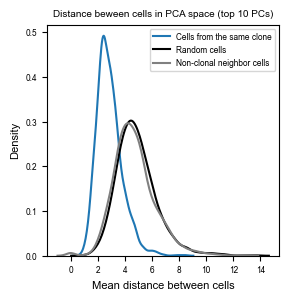

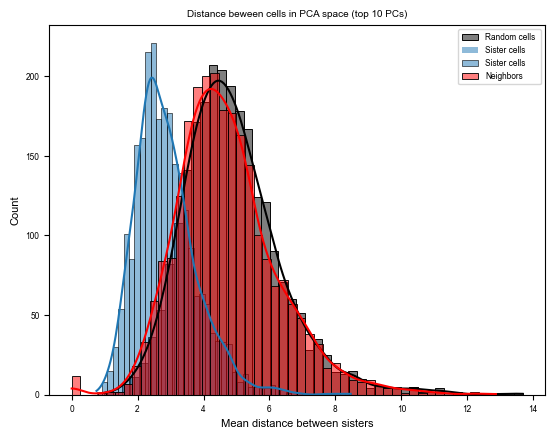

In [64]:
fig,ax = plt.subplots(figsize=(3,3))
sns.kdeplot(sister_more_dists,ax=ax,alpha=1.0,label='Cells from the same clone')
sns.kdeplot(randos,ax=ax,color='k',alpha=1.0,label='Random cells')
sns.kdeplot(neighbors,ax=ax,color='gray',alpha=1.0,label='Non-clonal neighbor cells')
# sns.histplot(neighbors,ax=ax,color='r',kde=True,alpha=0.5,label='Neighbors')
# sns.kdeplot(randos,ax=ax,color='gray',alpha=0.5)
# sns.kdeplot(sister_more_dists,ax=ax,alpha=0.5)
plt.legend()
plt.title(f'Distance beween cells in PCA space (top {pcs_to_use} PCs)')
plt.xlabel('Mean distance between cells')
plt.savefig(f'../graphs/sister_cell_distances_withrandom_{pcs_to_use}PCs.pdf',bbox_inches='tight')

fig,ax = plt.subplots()
sns.histplot(randos,ax=ax,color='k',kde=True,alpha=0.5,label='Random cells ')
sns.histplot(sister_more_dists,ax=ax,kde=True,alpha=0.5,label='Sister cells')
sns.histplot(neighbors,ax=ax,color='r',kde=True,alpha=0.5,label='Neighbors')
# sns.kdeplot(randos,ax=ax,color='gray',alpha=0.5)
# sns.kdeplot(sister_more_dists,ax=ax,alpha=0.5)
plt.legend()
plt.title(f'Distance beween cells in PCA space (top {pcs_to_use} PCs)')
plt.xlabel('Mean distance between sisters')
# plt.savefig(f'sister_cell_distances_withrandom_{pcs_to_use}PCs.pdf',bbox_inches='tight')

In [66]:
print('Sister mean:'
      ,np.nanmean(sister_more_dists),
      'Random mean:',np.nanmean(randos),
        'Neighbors mean:',np.nanmean(neighbors))

print('T-test for difference in means between random and sister cells:')
print(scipy.stats.ttest_ind(randos,sister_more_dists))
print('')
print('T-test for difference in means between neighbor and sister cells:')
print(scipy.stats.ttest_ind(neighbors,sister_more_dists))

Sister mean: 2.8670571786281767 Random mean: 4.874883629004997 Neighbors mean: 4.714526039398615
T-test for difference in means between random and sister cells:
Ttest_indResult(statistic=56.22659120585528, pvalue=0.0)

T-test for difference in means between neighbor and sister cells:
Ttest_indResult(statistic=50.856036331397895, pvalue=0.0)


In [67]:
sister_cells_more.items()

dict_items([('bc_001-bc_002-bc_003-bc_076-bc_083-bc_088', array([36155, 36533])), ('bc_001-bc_002-bc_005-bc_014-bc_063', array([11314, 11353])), ('bc_001-bc_002-bc_007-bc_065-bc_086', array([10093,  9955])), ('bc_001-bc_002-bc_011-bc_012-bc_067-bc_084-bc_085-bc_087', array([19658, 19772])), ('bc_001-bc_002-bc_012-bc_018-bc_048-bc_079', array([41261, 41330])), ('bc_001-bc_002-bc_013-bc_016-bc_051-bc_073', array([35058, 35139])), ('bc_001-bc_002-bc_013-bc_051-bc_063', array([34949, 34983])), ('bc_001-bc_002-bc_014-bc_020-bc_024-bc_064', array([14565, 14569])), ('bc_001-bc_002-bc_015-bc_033-bc_059-bc_060', array([35075, 35305])), ('bc_001-bc_002-bc_028-bc_067-bc_081-bc_095', array([30146, 30168])), ('bc_001-bc_002-bc_029-bc_035-bc_057', array([45158, 45193])), ('bc_001-bc_002-bc_030-bc_035-bc_048-bc_057-bc_059-bc_060-bc_066-bc_079', array([11707, 11844])), ('bc_001-bc_002-bc_030-bc_041-bc_083', array([23960, 24068, 24133])), ('bc_001-bc_002-bc_038-bc_040-bc_047-bc_088', array([32761, 3284

In [108]:
### PERFORM FISHER'S EXACT TEST ON SISTER CELLS, PRESENCE/ABSENCE OF GENE EXPRESSION

sister_more_dists = []
randos = []
neighbors= []
non_sister_neighbors = []

neighbor_distance = 1000

# all_ids = df.index
# all_ids = range(len(df))
all_ids = range(len(adata_genes))

np.random.seed(19104)

genes_to_use = ['IFIT2','OASL']

# gene_to_use = 'IFIT2'
# gene_to_use = 'OASL'
# gene_to_use = 'SFRP1'

cutoff = 0


for gene in genes_to_use:
    print(gene)

    sister_list = []
    randos_list = []
    neighbors_list = [] 

    for b,(bc_set,ix) in enumerate(sister_cells_more.items()):

        if len(ix) > 2:
            ix = np.random.choice(ix,2)

        sister_list.append(df.loc[ix][gene].values)

        randos_list.append(df.loc[np.random.choice(all_ids,len(ix))][gene].values)

        # neighbors of any random cell
        # random_cell = np.random.choice(all_ids,1)[0]
        # these_neighbors = find_neighbors(random_cell,square_distance_matrix,neighbor_distance)
        # neighbors_list.append(df.loc[np.random.choice(these_neighbors,len(ix))][gene_to_use ].values)

        # actual neighbors of one of the sisters
        these_neighbors = find_neighbors(ix[0],square_distance_matrix,neighbor_distance)
        neighbors_list.append(df.loc[np.random.choice(these_neighbors,len(ix))][gene ].values)

    sister_df = pd.DataFrame()
    sister_df['sister_A'] = np.asarray(sister_list)[:,0] > cutoff
    sister_df['sister_B'] = np.asarray(sister_list)[:,1] > cutoff

    sister_crosstab = pd.crosstab(sister_df['sister_A'],sister_df['sister_B'])
    print('Sister')
    print(sister_crosstab)
    print('Fisher exact test:',scipy.stats.fisher_exact(sister_crosstab),'\n')

    randos_df = pd.DataFrame()
    randos_df['sister_A'] = np.asarray(randos_list)[:,0] > cutoff
    randos_df['sister_B'] = np.asarray(randos_list)[:,1] > cutoff

    randos_crosstab = pd.crosstab(randos_df['sister_A'],randos_df['sister_B'])
    print('Random')
    print(randos_crosstab)
    print('Fisher exact test:',scipy.stats.fisher_exact(randos_crosstab),'\n')

    neighbors_df = pd.DataFrame()
    neighbors_df['sister_A'] = np.asarray(neighbors_list)[:,0] > cutoff
    neighbors_df['sister_B'] = np.asarray(neighbors_list)[:,1] > cutoff

    neighbors_crosstab = pd.crosstab(neighbors_df['sister_A'],neighbors_df['sister_B'])

    print('Neighbors')
    print(neighbors_crosstab)
    print('Fisher exact test:',scipy.stats.fisher_exact(neighbors_crosstab),'\n')


# # convert into a two by two matrix for each pair of sisters as to whether they are both above the cutoff
# sisters_matrix = np.zeros((2,2))
# randos_matrix = np.zeros((2,2))



IFIT2
Sister
sister_B  False  True 
sister_A              
False      2194    124
True        115     32
Fisher exact test: (4.923422159887798, 1.0297015164883539e-10) 

Random
sister_B  False  True 
sister_A              
False      2158    170
True        135      2
Fisher exact test: (0.18806100217864924, 0.005038743800817503) 

Neighbors
sister_B  False  True 
sister_A              
False      2158    157
True        132     18
Fisher exact test: (1.8743485813549507, 0.021278307682532593) 

OASL
Sister
sister_B  False  True 
sister_A              
False      2177    139
True        122     27
Fisher exact test: (3.4661516688288714, 8.903815287338822e-07) 

Random
sister_B  False  True 
sister_A              
False      2116    173
True        163     13
Fisher exact test: (0.9754955849498209, 1.0) 

Neighbors
sister_B  False  True 
sister_A              
False      2118    157
True        177     13
Fisher exact test: (0.9908237072222822, 1.0) 



In [72]:
print(f'Number of sister pairs: {len(sister_list)}')

Number of sister pairs: 2465


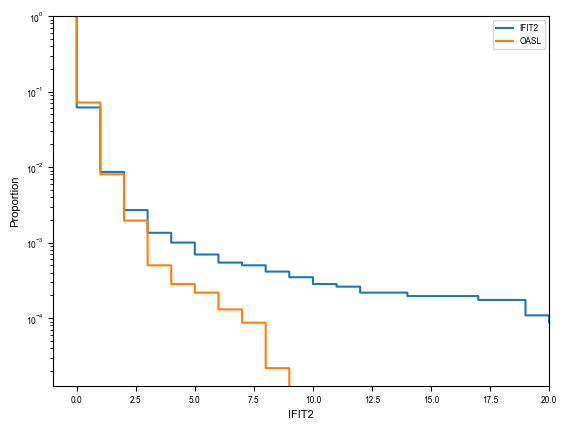

In [ ]:
for gene in genes_to_use:
    sns.ecdfplot(df[gene],complementary=True)
plt.legend(genes_to_use)
plt.xlim(-1,20)
plt.xlabel('Transcripts per cell')
plt.yscale('log')

# print(np.percentile(df['IFIT2'],90))